In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import pandas as pd

from src import eval_metrics
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

sns.set_theme("paper", style="whitegrid", font="serif", font_scale=2.4)
mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "lightgray"
mpl.rcParams["grid.linestyle"] = "--"
mpl.rcParams["grid.linewidth"] = 0.5

plt.rc("text", usetex=False)

In [ ]:
MODELS = {
    "Kiwi 22": {
        "model_id": "Unbabel--wmt22-cometkiwi-da",
        "type": "neural_metric"
    },
    "Kiwi 23 XL": {
        "model_id": "Unbabel--wmt23-cometkiwi-da-xl",
        "type": "neural_metric"
    },
    "Kiwi 23 XXL": {
        "model_id": "Unbabel--wmt23-cometkiwi-da-xxl",
        "type": "neural_metric"
    },
    "xCOMET XL": {
        "model_id": "Unbabel--XCOMET-XL",
        "type": "neural_metric"
    },
    "xCOMET XXL": {
        "model_id": "Unbabel--XCOMET-XXL",
        "type": "neural_metric"
    },
    "MetricX 23 L": {
        "model_id": "google--metricx-23-qe-large-v2p0",
        "type": "neural_metric"
    },
    "MetricX 23 XL": {
        "model_id": "google--metricx-23-qe-xl-v2p0",
        "type": "neural_metric"
    },
    "Mistral 7B": {
        "model_id": "mistralai--Mistral-7B-Instruct-v0.2",
        "type": "LLM"
    },
    "Llama 3.1 70B": {
        "model_id": "meta-llama--Meta-Llama-3.1-70B-Instruct",
        "type": "LLM"
    },
    "Gemma 2 9B": {
        "model_id": "google--gemma-2-9b-it",
        "type": "LLM"
    },
    "GPT 4o": {
        "model_id": "gpt-4o-2024-05-13",
        "type": "LLM"
    }
}

LANGS = ["ar", "de", "es", "fr", "hi", "it", "pt", "ru"]
RESULTS_DIR = "./results/scores/ambiguous/mtgeneval"


tot = list()

for lang in LANGS:
    # open source gender info file
    gender_info = pd.read_csv(f"./data/mtgeneval/context_genders/geneval-context-en{lang}-genders.txt", sep="\t")
    for m, info in MODELS.items():

        res = pd.read_csv(os.path.join(RESULTS_DIR,lang,f"{info['model_id']}/scores.csv"), sep=",")
        res["model"] = m
        res["lang"] = lang
        res["src_gender"] = gender_info["gender"]
        res["type"] = info["type"]
        res["target_original"] = res["score_Original"]
        res["target_flipped"] = res["score_Flipped"]
        tot.append(res)

res = pd.concat(tot)

res.drop(columns=["score_Original", "score_Flipped"], inplace=True)
res = res.rename(columns={"ID": "orig_id"})

In [3]:
res.tail(2)

,orig_id,context,source,reference_original,reference_flipped,model,lang,src_gender,type,target_original,target_flipped
1098,1098,Jurors accidentally overheard a sidebar disput...,After learning the jury had overheard this exc...,"Узнав, что присяжные подслушали этот обмен мне...","Узнав, что присяжные подслушали этот обмен мне...",GPT 4o,ru,female,LLM,85.0,85.0
1099,1099,"Fraleigh was born in 1976 in Beaufort, SC, and...",Fraleigh is an associate professor and the dep...,Фрэли — доцент и заведующая кафедрой художеств...,Фрэли — доцент и заведующий кафедрой художеств...,GPT 4o,ru,female,LLM,95.0,95.0


drop None values, normalize scores

In [4]:
final_df = list()
removed_info = list()
    
for lang in LANGS:

    curr_lang_df = res[res["lang"] == lang]
    lang_orig_ids = curr_lang_df["orig_id"].unique()
    orig_id_to_skip = set()
    lang_dfs = list()

    for model in MODELS.keys():

        subdf = curr_lang_df[curr_lang_df["model"] == model]
        initial_orig_id = subdf["orig_id"].unique()

        original_shape = subdf.shape
        
        # filter out all rows that have an empty score
        subdf = subdf.dropna(subset=["target_original", "target_flipped"])

        # rescale scores of LLMs from 0-100 to 0-1
        if subdf.iloc[0]["type"] == "LLM":
            subdf["target_original"] = subdf["target_original"] / 100
            subdf["target_flipped"] = subdf["target_flipped"] / 100

        if "metricx" in model.lower():
            subdf["target_original"] = 1 - subdf["target_original"] / 25
            subdf["target_flipped"] = 1 - subdf["target_flipped"] / 25
        
        # filter out all rows that have scores outside the range [0, 1]

        if subdf["type"][0] == "LLM":
            subdf = subdf.loc[
                (subdf["target_original"] > 0.1) & \
                (subdf["target_original"] <= 1) & \
                (subdf["target_flipped"] > 0.1) & \
                (subdf["target_flipped"] <= 1)
            ]

        subdf["score_M"] = subdf.apply(lambda x: x["target_original"] if x["src_gender"] == "male" else x["target_flipped"], axis=1)
        subdf["score_F"] = subdf.apply(lambda x: x["target_original"] if x["src_gender"] == "female" else x["target_flipped"], axis=1)

        # print(lang, model, subdf["score_M"].max(), subdf["score_M"].min())
        # print(lang, model, subdf["score_F"].max(), subdf["score_F"].min())

        final_orig_id = subdf["orig_id"].unique()
        orig_id_to_skip.update(set(initial_orig_id) - set(final_orig_id))
        

        removed_info.append({"lang": lang, "model": model, "removed": (1 - subdf.shape[0] / original_shape[0])})
        lang_dfs.append(subdf)

    # Concatenate results from all models
    curr_lang_df = pd.concat(lang_dfs)

    # filter out rows with orig_id that were removed in any of the models
    curr_lang_df = curr_lang_df[~curr_lang_df["orig_id"].isin(orig_id_to_skip)]
    print("For the language", lang, "we removed", len(lang_orig_ids) - len(curr_lang_df["orig_id"].unique()), "orig_ids")
    final_df.append(curr_lang_df)

final_df = pd.concat(final_df)
d = {"F": final_df["score_F"], "M": final_df["score_M"]}
final_df["ratio"] = eval_metrics.Ratio(d).vector()
final_df["ratio_parity_gap"] = final_df["ratio"] - 1
final_df["diff"] = eval_metrics.Difference(d).vector()

print("#" * 80)
print("Summary of final data:")
final_df.describe()

For the language ar we removed 41 orig_ids
For the language de we removed 45 orig_ids
For the language es we removed 20 orig_ids
For the language fr we removed 8 orig_ids
For the language hi we removed 13 orig_ids
For the language it we removed 27 orig_ids
For the language pt we removed 21 orig_ids
For the language ru we removed 14 orig_ids
################################################################################
Summary of final data:


,orig_id,target_original,target_flipped,score_M,score_F,ratio,ratio_parity_gap,diff
count,94457.000000,94457.000000,94457.000000,94457.000000,94457.000000,94457.000000,9.445700e+04,94457.000000
mean,548.386282,0.890351,0.879232,0.895107,0.874477,0.977724,-2.227605e-02,-0.020630
std,316.801855,0.113430,0.120655,0.111130,0.122161,0.082390,8.239029e-02,0.062605
min,0.000000,0.000000,0.028025,0.043931,0.000000,0.000000,-1.000000e+00,-0.999826
25%,273.000000,0.845585,0.822295,0.850000,0.813138,0.976786,-2.321418e-02,-0.020000
50%,548.000000,0.930793,0.900000,0.942952,0.900000,1.000000,-1.250000e-11,0.000000
75%,823.000000,0.978444,0.973600,0.980000,0.969504,1.000000,-1.000000e-11,0.000000
max,1099.000000,1.000000,1.000000,1.000000,1.000000,5.465073,4.465073e+00,0.773425


In [5]:
removed_info = pd.DataFrame(removed_info)
removed_info

,lang,model,removed
0,ar,Kiwi 22,0.000000
1,ar,Kiwi 23 XL,0.000000
2,ar,Kiwi 23 XXL,0.000000
3,ar,xCOMET XL,0.000000
4,ar,xCOMET XXL,0.000000
...,...,...,...
83,ru,MetricX 23 XL,0.000000
84,ru,Mistral 7B,0.000000
85,ru,Llama 3.1 70B,0.001818
86,ru,Gemma 2 9B,0.000909


In [ ]:
# stats_df = final_df.pivot_table(index=["lang", "model"], values=["ratio", "diff"], aggfunc={"ratio": ["mean", "std"], "diff": ["mean", "std"] }).reset_index()
# stats_df.columns = [f"{col[0]}_{col[1]}" if col[1] != "" else col[0] for col in stats_df.columns]
# stats_df.head(3) (used for pareto frontier plot)


In [10]:
final_df.head(3)

,orig_id,context,source,reference_original,reference_flipped,model,lang,src_gender,type,target_original,target_flipped,score_M,score_F,ratio,ratio_parity_gap,diff
0,0,"In his personal life, Student remains involved...","According to Student, I live in a moderate Har...",وفقاً لما قاله الطالب، أعيش في ضاحية Haredi ال...,وفقاً لما قالته الطالبة، أعيش في ضاحية Haredi ...,Kiwi 22,ar,male,neural_metric,0.789750,0.788910,0.789750,0.788910,0.998936,-0.001064,-0.000840
1,1,He received his M.A. in English from McGill Un...,"Professionally, Hayakawa was a linguist, psych...",بشكل احترافي، كان Hayakawa لغوي وعالم نفس وعال...,بشكل احترافي، كانت Hayakawa لغوية وعالمة نفس و...,Kiwi 22,ar,male,neural_metric,0.815024,0.835426,0.815024,0.835426,1.025033,0.025033,0.020402
2,2,"Slap-guitarist Miyavi, who has his roots in vi...",It was the most successful international tour ...,كانت من أنجح الرحلات الدولية التي نفذها فنان ي...,كانت من أنجح الرحلات الدولية التي نفذتها فنانة...,Kiwi 22,ar,male,neural_metric,0.859569,0.856059,0.859569,0.856059,0.995917,-0.004083,-0.003510


Create density plots

In [16]:
# plt.rcParams['text.usetex'] = False  # Disable LaTeX processing

# non_llm_models = [
#     "Kiwi 22", "",
#     "Kiwi 23 XL",
#     "Kiwi 23 XXL",
#     "xCOMET XL", 
#     "xCOMET XXL", 
#     "MetricX 23 L",
#     "MetricX 23 XL"
# ]

# llm_models = [
#     "Mistral 7B",
#     "Gemma 2 9B",
#     "Llama 3.1 70B",
#     "GPT 4o"
# ]

# for tgt_lang in LANGS:
#     lang_df = final_df[final_df["lang"] == tgt_lang]

#     fig, axes = plt.subplots(figsize=(12, 36), ncols=2, nrows=6, dpi=120)
#     fig.subplots_adjust(hspace=0.25)

#     for idx, model_name in enumerate(non_llm_models + llm_models):
#         if idx == 1:  # Skip axes[0, 1]
#             continue
#         subdf = lang_df[lang_df["model"] == model_name]
#         ax = axes[idx // 2, idx % 2]

#         sns.kdeplot(data=subdf, x="score_M", ax=ax, fill=True, label="Male")
#         sns.kdeplot(data=subdf, x="score_F", ax=ax, fill=True, label="Female")
#         ax.set_xlabel(model_name)
#         ax.set_xticks([0, 0.25, 0.5, 0.75, 1])

#         if idx % 2 != 0:
#             ax.set_ylabel("")

#         if idx == 0:
#             ax.legend(title="", bbox_to_anchor=(1.05, 1), loc='upper left')

#     fig.delaxes(axes[0, 1])
#     fig.savefig(f"./plots/ambiguous/density_plots/kde_{tgt_lang}_MT-GenEval_contextual_ambiguous.pdf", bbox_inches="tight")
#     plt.close(fig)  # Close the figure to avoid display in Jupyter Notebook

Paper plots and Tables for ambiguous case

In [17]:
# Create a new dataframe with the required transformations
expanded_df = pd.DataFrame()

# Create rows for male gender
male_df = final_df.copy()
male_df["gender"] = "male"
male_df["score"] = male_df["score_M"]

# Create rows for female gender
female_df = final_df.copy()
female_df["gender"] = "female"
female_df["score"] = female_df["score_F"]

# Concatenate the male and female dataframes
expanded_df = pd.concat([male_df, female_df], ignore_index=True)

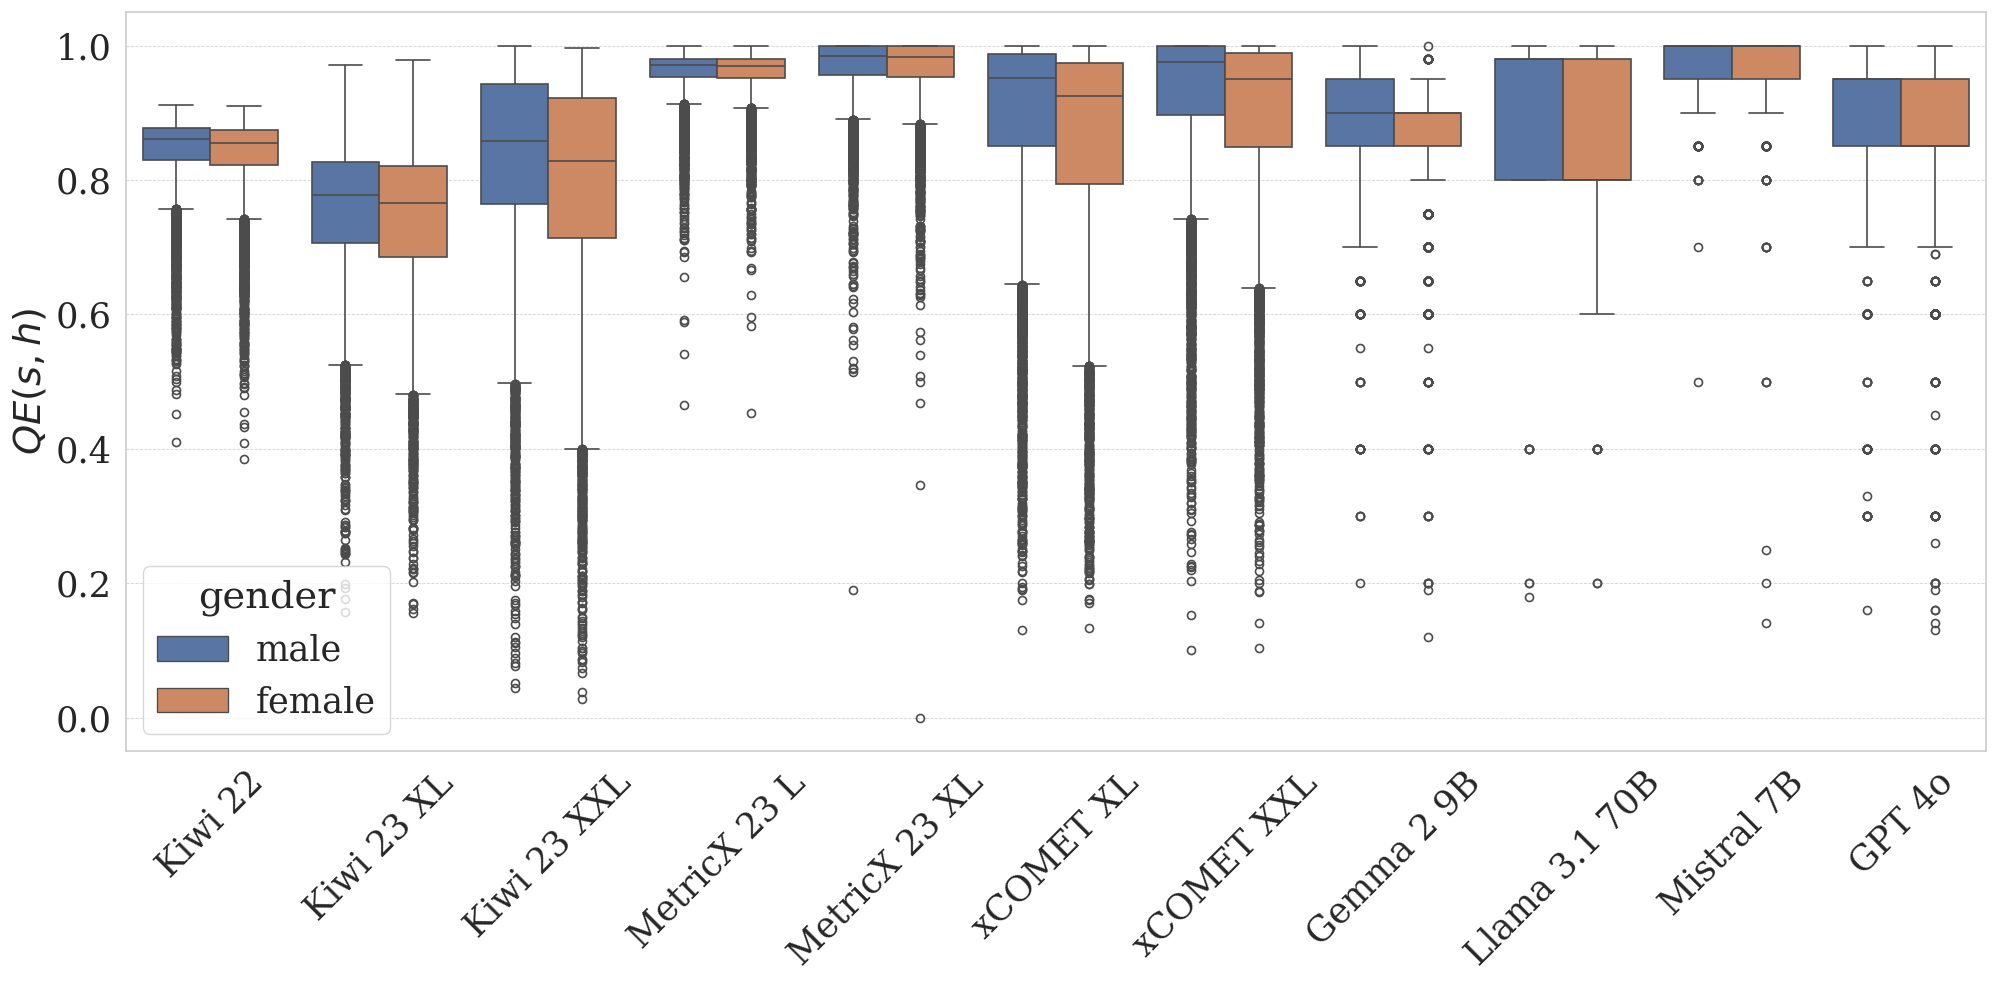

In [18]:
plt.rcParams['text.usetex'] = False  # Disable LaTeX processing

fig, ax = plt.subplots(figsize=(20, 8), dpi=120)
# sns.violinplot(data=expanded_df, x="model", y="score", hue="gender", split=True, inner="quart", cut=0)
model_order = sorted(expanded_df["model"].unique(), key=lambda x: (MODELS[x]["type"] == "LLM", x if x != "GPT 4o" else "zzzz"))
sns.boxplot(data=expanded_df, x="model", y="score", hue="gender", ax=ax, order=model_order)
plt.xticks(rotation=45)

ax.set_ylabel("$QE(s,h)$")
ax.set_xlabel("")
fig.savefig("./plots/ambiguous/mtgeneval/raw-QE_MT-GenEval_contextual_ambiguous.pdf", bbox_inches="tight")

In [19]:
stats = list()
for (model, lang), subdf in final_df.groupby(["model", "lang"]):
    s = {"lang": lang, "model": model}
    scores_d = {"F": subdf["score_F"], "M": subdf["score_M"]}
    
    m = eval_metrics.Ratio(scores_d)
    value, p_value, sig = m.score()
    s["ratio_mean"] = value.mean()
    s["ratio_std"] = value.std()
    s["ratio_1samp_p"] = p_value
    
    m = eval_metrics.Difference(scores_d)
    value, p_value, sig = m.score()
    s["diff_mean"] = value.mean()
    s["diff_std"] = value.std()
    s["ratio_1samp_p"] = p_value

    stats.append(s)


In [20]:
stats_df = pd.DataFrame(stats)
stats_df.describe()

,ratio_mean,ratio_std,ratio_1samp_p,diff_mean,diff_std
count,88.000000,88.000000,8.800000e+01,88.000000,88.000000
mean,0.977749,0.067599,5.598571e-03,-0.020610,0.052218
std,0.018160,0.043913,4.070704e-02,0.017010,0.030324
min,0.932723,0.004831,2.693378e-81,-0.060734,0.004478
25%,0.964530,0.025993,3.289597e-45,-0.032900,0.022413
50%,0.978273,0.071188,1.689674e-26,-0.019065,0.054649
75%,0.994856,0.097135,1.938338e-10,-0.004996,0.076022
max,1.001191,0.220777,3.781645e-01,-0.000100,0.109331


In [21]:
# pivot=stats_df.pivot_table(index="model", columns="lang")
pivot=stats_df.pivot_table(index=["lang", "model"]).reset_index()
pivot

,lang,model,diff_mean,diff_std,ratio_1samp_p,ratio_mean,ratio_std
0,ar,GPT 4o,-0.037054,0.096394,6.938099e-34,0.962803,0.177511
1,ar,Gemma 2 9B,-0.025619,0.083126,5.625531e-23,0.972486,0.105088
2,ar,Kiwi 22,-0.009237,0.030039,6.899752e-23,0.988423,0.039052
3,ar,Kiwi 23 XL,-0.009472,0.057033,4.014352e-08,0.987992,0.091112
4,ar,Kiwi 23 XXL,-0.036305,0.096009,6.390527e-33,0.951058,0.139938
...,...,...,...,...,...,...,...
83,ru,MetricX 23 L,-0.003542,0.014662,2.132983e-15,0.996220,0.015761
84,ru,MetricX 23 XL,-0.002637,0.022078,4.407636e-05,0.997450,0.024135
85,ru,Mistral 7B,-0.004890,0.030300,6.373317e-08,0.995106,0.030368
86,ru,xCOMET XL,-0.020882,0.049600,1.030650e-40,0.977362,0.057931


/tmp/ipykernel_1020795/182852531.py:21: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.barplot(data=curr_df, x="lang", y="ratio_parity_gap", hue="model", ax=ax, hue_order=g, palette=palette)
/tmp/ipykernel_1020795/182852531.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{tick + 1:.2f}" for tick in ax.get_yticks()])
/tmp/ipykernel_1020795/182852531.py:21: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.barplot(data=curr_df, x="lang", y="ratio_parity_gap", hue="model", ax=ax, hue_order=g, palette=palette)
/tmp/ipykernel_1020795/182852531.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{tick + 1:.2f}" for tick in ax.get_yticks()])


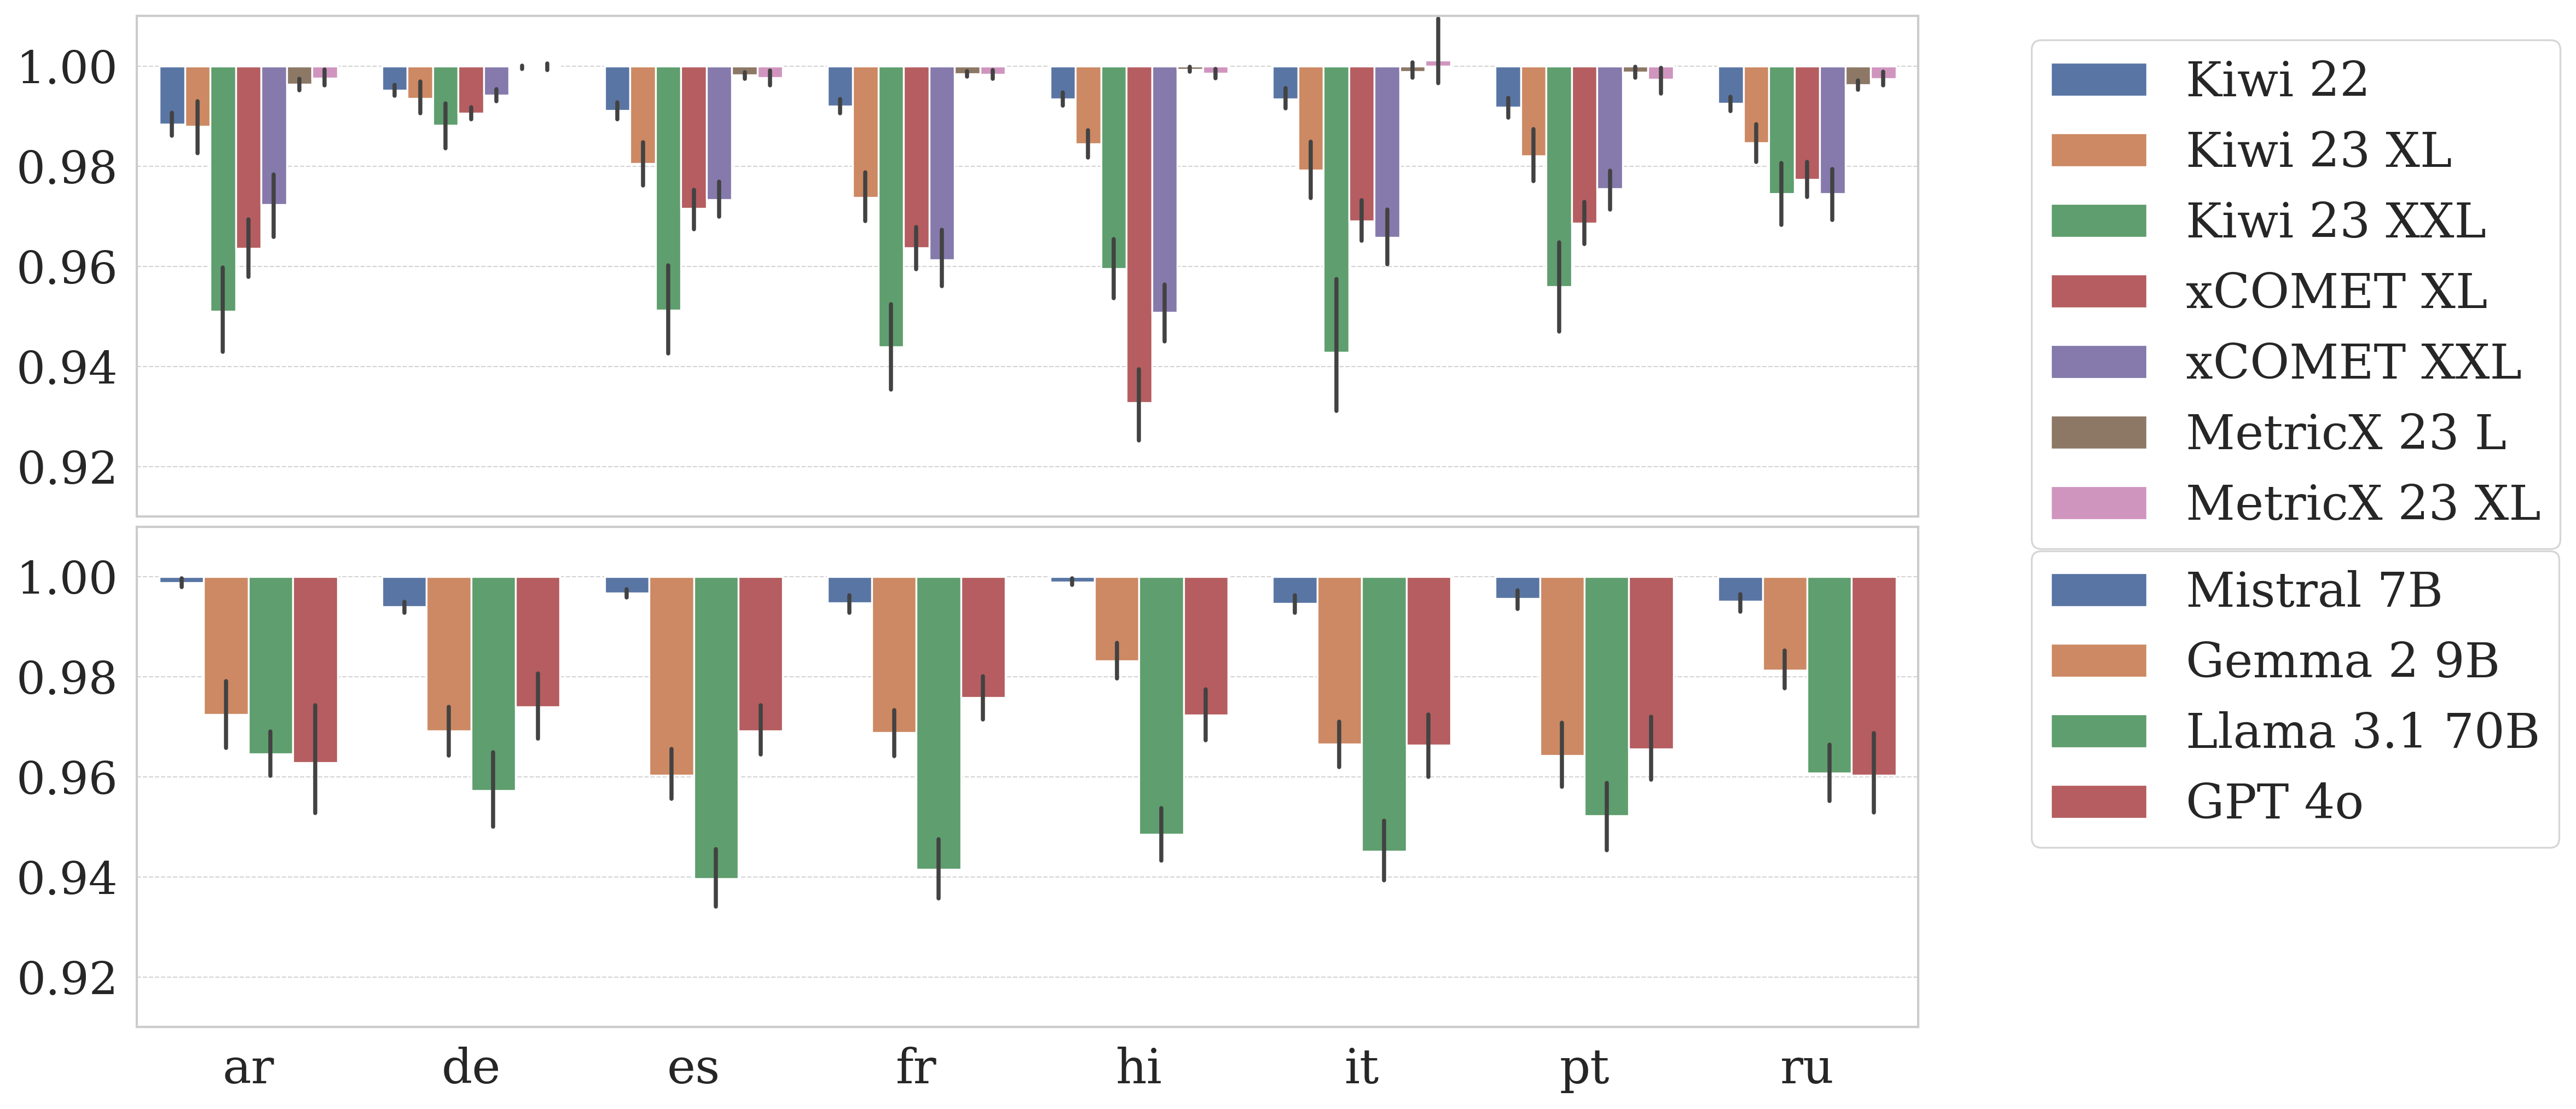

In [22]:
fig, axes = plt.subplots(figsize=(14, 8), nrows=2, sharex=True, dpi=300)
fig.subplots_adjust(hspace=0.02)

groups = [
    ["Kiwi 22", "Kiwi 23 XL", "Kiwi 23 XXL", "xCOMET XL", "xCOMET XXL", "MetricX 23 L", "MetricX 23 XL"],
    ["Mistral 7B", "Gemma 2 9B", "Llama 3.1 70B", "GPT 4o"]
]

_palette = sns.color_palette(n_colors=len(groups[0]) + len(groups[1]))
palette = [
    _palette[:len(groups[0])],
    _palette[len(groups[0]):]
]
palette = sns.color_palette()


for idx, (ax, g) in enumerate(zip(axes, groups)):
    curr_df = final_df[final_df["model"].isin(g)]    
    # ax.set_ylabel(r"$QE(s,h_F)/QE(s,h_M)$")

    sns.barplot(data=curr_df, x="lang", y="ratio_parity_gap", hue="model", ax=ax, hue_order=g, palette=palette)

    ax.legend(title="")
    ax.set_xlabel("")
    ax.set_ylim(-0.09, 0.01)

    ax.legend(title="", bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.tick_params(axis='y', labelsize=20)
    ax.set_yticklabels([f"{tick + 1:.2f}" for tick in ax.get_yticks()])
    ax.set_ylabel("")

fig.savefig("./plots/ambiguous/mtgeneval/ratio-bars_MT-GenEval_contextual_ambiguous.pdf", bbox_inches="tight")